<a href="https://colab.research.google.com/github/shineloveyc/hands-on-ML-Practice/blob/main/Housing_Price_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Housing Price Prediction Project**

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/'
os.chdir(base_dir)
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/My Drive/Colab Notebooks'

In [ ]:
import tarfile
import urllib.request as request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

HOUSING_PATH = os.path.join("data", "housing")

HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [ ]:
#build a function to fetch the data
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
  #make directory in the workspace
  os.makedirs(housing_path, exist_ok = True)
  #get web path to download the data, the file name could be change
  tgz_path = os.path.join(housing_path, "housing.tgz")
  #Copy a network object denoted by a URL to a local file.which is tgz_path
  request.urlretrieve(housing_url, tgz_path)
  #read from and write to tar format archives.
  housing_tgz = tarfile.open(tgz_path)
  #extract all the files to local directory
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
#loading the data by writing resuable function
import pandas as pd

def load_data(housing_path = HOUSING_PATH):
  #file name could be change
  csv_path = os.path.join(housing_path, "housing.csv")
  return pd.read_csv(csv_path)

In [ ]:
housing = load_data()
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
#get quick description of data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
#check how many categories exist
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
#get summary of numberic predictors
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


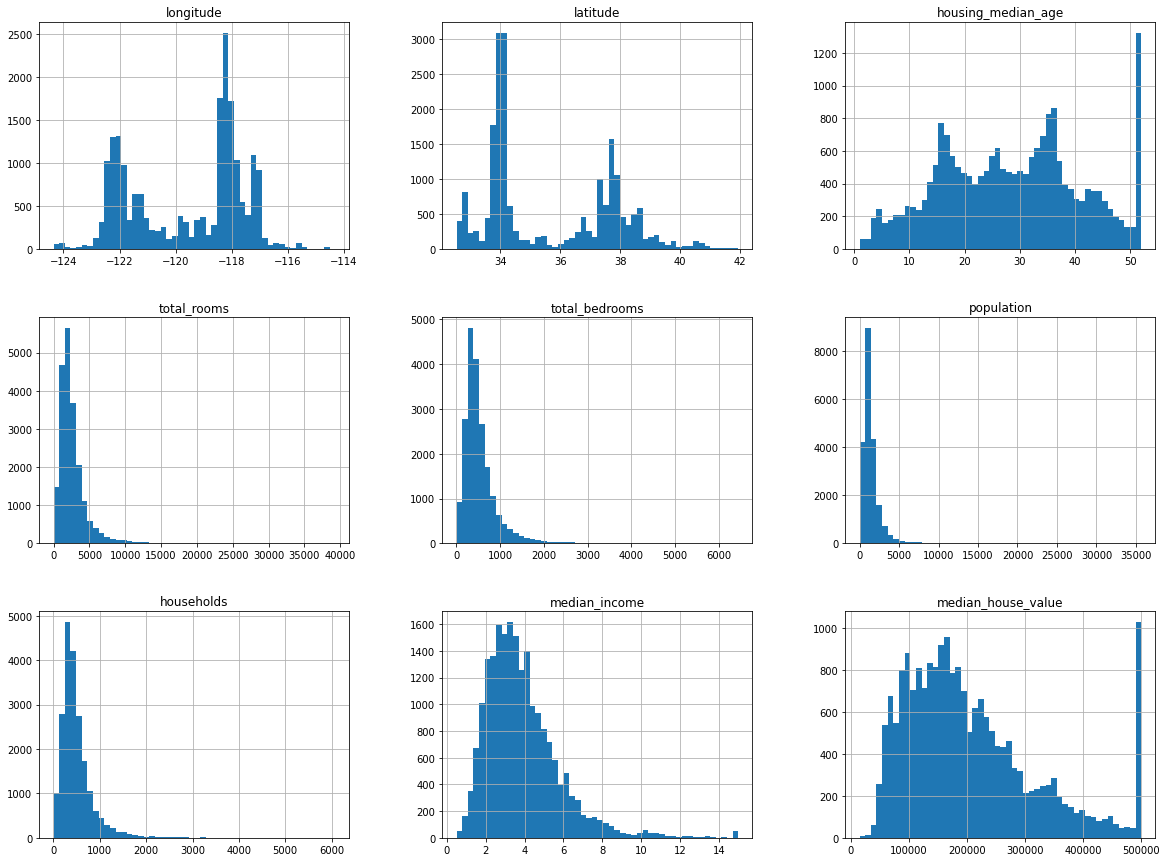

In [ ]:
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize=(20,15))
plt.show()

* Note: meidan income data has been scaled and capped at 15 for high income and 0.5 for low income(number represent ten thousands of dollars)
* house median age and median house value were also capped
* many histograms are tail-heavy==>need to transfer to bell shape

In [ ]:
#create test set
import numpy as np

def split_train_test(data, test_ratio):
  """Randomly permute a sequence, or return a permuted range.
      seed make sure everytime the index return is the same"""
  np.random.seed(42)
  #shuffle the index by using permutation
  shuffled_indices = np.random.permutation(len(data))
  #get size of the test data
  test_set_size = int(len(data)*test_ratio)

  """split train and test data"""
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
train_set, test_set = split_train_test(housing, 0.2)
len(test_set)

4128

* Data snooping problem<br>
One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42))14 before calling np.random.permutation() so that it always generates the same shuffled indices.
But both these solutions will break the next time you fetch an updated dataset. To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). 

In [ ]:
#hash identifier
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio*2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]

  in_test_set = ids.apply(lambda id_:test_set_check(id_, test_ratio))

  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
#using row index to split the data
housing_with_id = housing.reset_index() #add index column by using row index

train_set,test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [ ]:
#create another UID to split the data
housing_with_id['id'] = housing_with_id["longitude"]*1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

* avoid sampling bias <br>
1. stratified sampling <br>
stratified sampling: the population is divided into homogeneous subgroups called strata, and the right number of instances are sampled from each stratum to guarantee that the test set is representative of the overall population. 

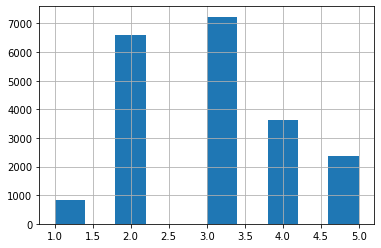

In [ ]:
#divde income to strata
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins = [0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels = [1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [ ]:
#implement stratified sampling based on income category

from sklearn.model_selection import StratifiedShuffleSplit
#n_splits : int, default 10 Number of re-shuffling & splitting iterations.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [ ]:
strat_train_set["income_cat"].value_counts()/len(strat_test_set)

3    1.402374
2    1.275436
4    0.705184
5    0.457607
1    0.159399
Name: income_cat, dtype: float64

In [ ]:
#drop income category
"""Sometimes if you want to use Python Keywords as a variable, function or class names, 
   you can use this convention for that."""
for set_ in (strat_train_set, strat_test_set):
      set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


* Data visualization

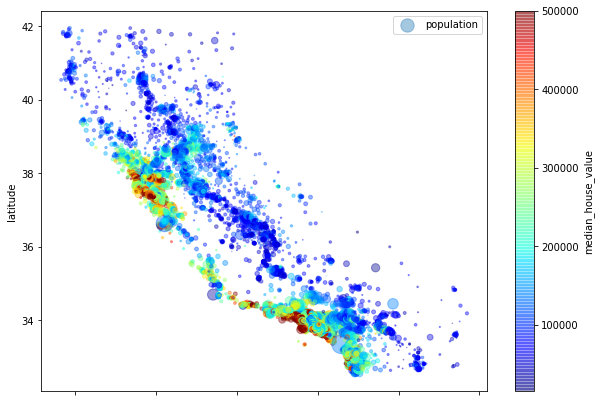

In [ ]:
#plot geo information reflect density
"""radius represent district's population=size
   color represent the price(blue=low), (red(high))"""
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             s = housing["population"]/100, label = "population", figsize = (10,7),
             c="median_house_value", cmap =plt.get_cmap("jet"), colorbar = True, 
             )
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. A clustering algorithm should be useful for detecting the main cluster and for adding new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

* Data correlation anaysis

In [ ]:
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd295d47940>,
      dtype=object)

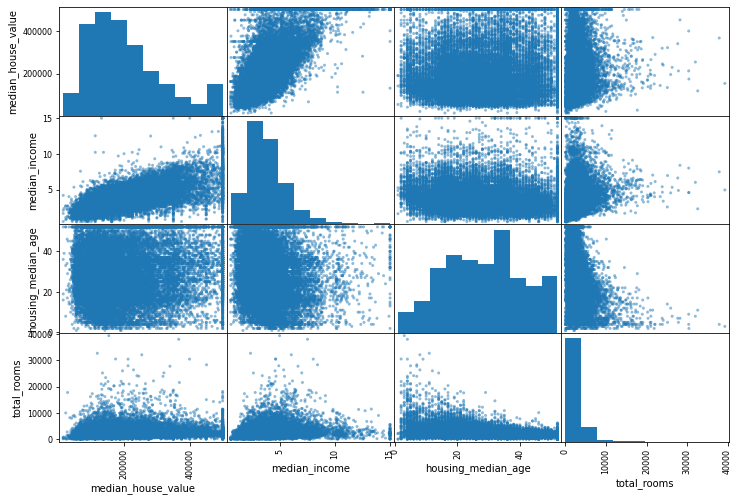

In [ ]:
#visualize the correlation
from pandas.plotting import scatter_matrix

attributes = ['median_house_value','median_income','housing_median_age', 'total_rooms']

scatter_matrix(housing[attributes], figsize = (12, 8))

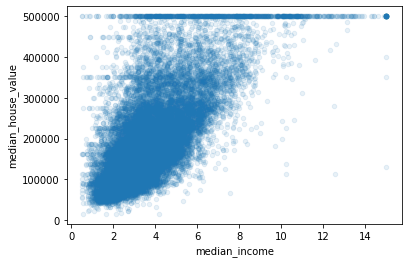

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
               alpha=0.1)

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend, and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at $500,000. But this plot reveals other less obvious straight lines: a horizontal line around $450,000, another around $350,000, perhaps one around $280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

* try variables combination ==>feature engineering

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

housing["population_per_household"] = housing["population"]/housing["households"]

In [ ]:
#check the correlation matrix again
corr_matrix = housing.corr()

corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

* Data Cleaning

In [ ]:
#get the training set
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
"""data imputation
  1. Get rid of the corresponding districts.
  2. Get rid of the whole attribute.
  3. Set the values to some value(zero,themean,themedian,etc.).
"""
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

#create a copy of housing df as imputer can only deal with numberic data
housing_num = housing.drop("ocean_proximity", axis = 1)

imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [ ]:
"""The imputer has simply computed the median of each attribute and 
    stored the result in its statistics_ instance variable."""
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
"""use this “trained” imputer to transform the training set by replacing missing values with the learned medians:"""
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index = housing_labels.index)

* process category data

In [ ]:
"""ordinal encoding"""
housing_cat = housing[['ocean_proximity']]

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
#get list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
"""one-hot encoding"""
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()

housing_cat_1hot = one_hot_encoder.fit_transform(housing_cat)

In [ ]:
housing_cat_1hot
"""the output is a sparse matrix, to save space, but can be converted 
to dense array by calling housing_cat_1hot.toarray()"""

'the outout is a sparse matrix, to save space, but can be converted \nto dense array by calling housing_cat_1hot.toarray()'

If a categorical attribute has a large number of possible categories (e.g., country code, profession, species), then one-hot encoding will result in a large number of input features. This may slow down training and degrade performance. If this happens, you may want to replace the categorical input with useful numerical features related to the categories: for example, you could replace the ocean_proximity feature with the distance to the ocean (similarly, a country code could be replaced with the country’s population and GDP per capita). Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. Each category’s representation would be learned during training. This is an example of representation learning (see Chapters 13 and 17 for more details).

* create customized transformers
1. transformer that adds new features

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedroomx_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
    self.add_bedrooms_per_room = add_bedrooms_per_room

  def fit(self, X, y=None):
    return self #nothing else to do
  
  def transform(self, X, y = None):
    rooms_per_household = X[:, room_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    #add_bedrooms_per_room is a hyperparameter==>used to gate any data preparation setp that you are not 100% sure about
    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedroomx_ix] / X[:, room_ix]
      #Translates slice objects to concatenation along the second axis.
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

2. transformer that select only the most important features

In [ ]:
"""Note: this feature selector assumes that you have already computed the feature importances 
   somehow (for example using a RandomForestRegressor). 
   You may be tempted to compute them directly in the TopFeatureSelector's fit() method, 
   however this would likely slow down grid/randomized search since the feature importances would have to be 
   computed for every hyperparameter combination (unless you implement some sort of cache)."""

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        #return estimator
        return self
        #return transformed dataset
    def transform(self, X):
        return X[:, self.feature_indices_]


* Feature Scaling

In [ ]:
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
#build pipeline to stream the numberic data processing
num_pipeline = Pipeline([
      ('imputer', SimpleImputer(strategy='median')),
      ('att_adder', CombinedAttributesAdder()),
      #note, the last estimator must be transformers==>have fit_transform() method
      ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
#get columns header for numberic data
num_att = list(housing_num)
num_att

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [ ]:
#combine numeric and categorical data engineering together

from sklearn.compose import ColumnTransformer
cat_att = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ('num',num_pipeline, num_att),
        ('cat', OneHotEncoder(), cat_att),                          
])

#transform the training data set
housing_prepared = full_pipeline.fit_transform(housing)

* Training the model



1.   Linear Regression



In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
#test the sample of predictions
some_data = housing.iloc[:5]

some_labels = housing_labels.iloc[:5]

#using the paramenter from the full pipeline to transform the data
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
#measure the performance by using RMSE
from sklearn.metrics import mean_squared_error, median_absolute_error

In [ ]:
housing_pred = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

* median_housing_values range between $120,000 and $265,000, so a typical
prediction error of $68,628 is not very satisfying.==>model underfitting
* As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. You could try to add more features (e.g., the log of the population), but first let’s try a more complex model to see how it does.

2. DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree = DecisionTreeRegressor()
tree.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
housing_tree_pred = tree.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_tree_pred)

tree_rmse = np.sqrt(tree_mse)

print("Decision Tree Regressor RMSE is: ", tree_rmse)

Decision Tree Regressor RMSE is:  0.0


Model become overfit, using cross_valiodation

In [ ]:
#k-fold cross-validation
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(tree, housing_prepared, housing_labels,
                         scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
#print out result
def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard deviation: ", scores.std())
display_scores(tree_rmse_scores)

Scores:  [69327.01708558 65486.39211857 71358.25563341 69091.37509104
 70570.20267046 75529.94622521 69895.20650652 70660.14247357
 75843.74719231 68905.17669382]
Mean:  70666.74616904806
Standard deviation:  2928.322738055112


In [ ]:
#get the same scores for linear regression

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv =10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation:  2731.674001798344


3. Random Forest Regressor==>part of the Ensemble Learning Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor
for_reg = RandomForestRegressor()
for_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
for_scores = cross_val_score(for_reg, housing_prepared, housing_labels,
                             scoring = "neg_mean_squared_error", cv =10)
for_rmse_scores = np.sqrt(-for_scores)
display_scores(for_rmse_scores)

Scores:  [49557.6095063  47584.54435547 49605.349788   52325.13724488
 49586.9889247  53154.87424699 48800.48987508 47880.32844243
 52958.68645964 50046.17489414]
Mean:  50150.018373763225
Standard deviation:  1902.0697041387534


4. Support Vector Machine Regressor

In [ ]:
from sklearn.svm import SVR
svr_para_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
                ]
svr = SVR()

svr_grid_search = GridSearchCV(svr, svr_para_grid, cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)
svr_grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
#get best parameters
svr_grid_search.best_params_

{'C': 1000, 'kernel': 'linear'}

In [ ]:
#get the best estimator directly
svr_grid_search.best_estimator_

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
#get the evaluation scores
svr_cvres = svr_grid_search.cv_results_
for mean_score, params in zip(svr_cvres["mean_test_score"], svr_cvres["params"]):
  print(np.sqrt(-mean_score), params)

118909.34725523094 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
118921.75548994428 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
118785.93684936815 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
118909.04076209712 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
117624.56209896787 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
118783.0091511396 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
107358.79831098409 {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
117595.97985628908 {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
112571.9845974018 {'C': 1, 'kernel': 'linear'}
84654.24944894915 {'C': 10, 'kernel': 'linear'}
71603.17710755806 {'C': 100, 'kernel': 'linear'}
70445.3835347414 {'C': 1000, 'kernel': 'linear'}


Note: the rmse for validation set is still higher than that of the training set-->overfitting

* Save trained models

In [ ]:
#joblib and pickle both can be used to store the models
import joblib

joblib.dump(for_reg, "for_reg.pkl")

['for_reg.pkl']

In [ ]:
#to load the model
for_reg_model_loaded = joblib.load("for_reg.pkl")

* Fine-Tune the model
1. Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
#different hyper-parameters combination = 3*4 + 2*3 = 18
para_grid = [{'n_estimators': [3, 10, 30], 'max_features':[2,4,6,8]},
             {'bootstrap':[False], 'n_estimators':[3, 10] , 'max_features':[2, 3,4]}
             ]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, para_grid, cv = 5,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
#get best parameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

Since 8 and 30 are the maximum values that were evaluated, you should probably try searching again with higher values; the score may continue to improve.

In [ ]:
#get the best estimator directly
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
#get the evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

63433.40391736115 {'max_features': 2, 'n_estimators': 3}
56049.06443637957 {'max_features': 2, 'n_estimators': 10}
52824.848527310685 {'max_features': 2, 'n_estimators': 30}
60924.41328448018 {'max_features': 4, 'n_estimators': 3}
52713.650694157855 {'max_features': 4, 'n_estimators': 10}
50660.92190603788 {'max_features': 4, 'n_estimators': 30}
59604.01184459288 {'max_features': 6, 'n_estimators': 3}
52347.604952708156 {'max_features': 6, 'n_estimators': 10}
49923.3473574243 {'max_features': 6, 'n_estimators': 30}
59308.345962472304 {'max_features': 8, 'n_estimators': 3}
52320.77872780119 {'max_features': 8, 'n_estimators': 10}
50080.73594153239 {'max_features': 8, 'n_estimators': 30}
62160.41351492645 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54391.4645181866 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60269.48857946438 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52791.4337224519 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

* Randomized Search
The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.
* Ensemble Methods
Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. We will cover this topic in more detail in Chapter 7.


In [ ]:
#inspect the best model
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.55720671e-02, 6.39878625e-02, 4.24072059e-02, 1.82928273e-02,
       1.68924417e-02, 1.75601900e-02, 1.66881781e-02, 3.03268232e-01,
       6.31565549e-02, 1.08958622e-01, 8.44196144e-02, 8.53515062e-03,
       1.73063945e-01, 8.08024120e-05, 2.96250425e-03, 4.15380176e-03])

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold",
  "bedrooms_per_room"]
# get encoder from the pipeline
cat_encoder = full_pipeline.named_transformers_["cat"]
#get the list of one hot variable's columns' name
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_att + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.303268232301214, 'median_income'),
 (0.1730639450304893, 'INLAND'),
 (0.10895862174634888, 'pop_per_hhold'),
 (0.0844196144263057, 'bedrooms_per_room'),
 (0.07557206707255014, 'longitude'),
 (0.06398786252477989, 'latitude'),
 (0.06315655490931624, 'rooms_per_hhold'),
 (0.04240720593117474, 'housing_median_age'),
 (0.01829282732311651, 'total_rooms'),
 (0.017560189966804522, 'population'),
 (0.01689244166020893, 'total_bedrooms'),
 (0.01668817806453196, 'households'),
 (0.008535150622100876, '<1H OCEAN'),
 (0.0041538017589390725, 'NEAR OCEAN'),
 (0.0029625042500806965, 'NEAR BAY'),
 (8.080241203860085e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).
You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.).

In [ ]:
#test the feature_selector
k = 5

top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [ ]:
np.array(attributes)[top_k_feature_indices]

#create a new pipeline to test new transformer
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)
housing_prepared_top_k_features[0:3]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ]])

2.Randomized Search Crossvalidation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
"""n_estimators: number of trees, 
   max_features: max number of features considered for splitting a node,
   max_depth: max number of levels in each decision tree,
   min_samples_split: min number of data points placed in a node before the node is split
   min_samples_leaf: min number of data points allowed in a leaf node
   bootstrap: method for sampling data points (with or without replacement)"""

# Number of trees in random forest
#Return evenly spaced numbers over a specified interval.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
"""Number of features to consider at every split
   If “auto”, then max_features=sqrt(n_features).
   If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
"""
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
      
forest_reg = RandomForestRegressor()

random_grid_search = RandomizedSearchCV(forest_reg, random_grid, cv = 3,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True, n_jobs = -1, verbose = 2)
random_grid_search.fit(housing_prepared, housing_labels)

    

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
#create a single pipeline that does data preparation and predict
preparation_feature_selection_and_predict_pipeline=Pipeline([
     ('prep_and_select', preparation_and_feature_selection_pipeline),
     ('random_for_predict', RandomForestRegressor(**random_grid_search.best_params_))
     ])                                                 

In [ ]:
preparation_feature_selection_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('prep_and_select',
                 Pipeline(memory=None,
                          steps=[('preparation',
                                  ColumnTransformer(n_jobs=None,
                                                    remainder='drop',
                                                    sparse_threshold=0.3,
                                                    transformer_weights=None,
                                                    transformers=[('num',
                                                                   Pipeline(memory=None,
                                                                            steps=[('imputer',
                                                                                    SimpleImputer(add_indicator=False,
                                                                                                  copy=True,
                                                                                 

In [ ]:
#test the sample of predictions
some_data = housing.iloc[:5]

some_labels = housing_labels.iloc[:5]

print("Predictions:", preparation_feature_selection_and_predict_pipeline.predict(some_data))

print("Labels:", list(some_labels))

Predictions: [264323.07091667 344099.89641667 199636.60833333  50509.175
 245617.81716667]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


* Test set evaluation

In [ ]:
"""run your full_pipeline to transform the data (call transform(), not fit_transform()—
    you do not want to fit the test set!), 
    and evaluate the final model on the test set:"""
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis =1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_pred = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_pred)

final_rmse = np.sqrt(final_mse)

final_rmse

48760.26530172545

In [ ]:
"""compute 95% confidence internal for the generalization error 
   becasue sometimes a point of the generalization error is not sufficient, you need a confidence interva;"""

from scipy import stats
confidence = 0.95

squared_errors = (final_pred-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, # sample size-1
                          loc = squared_errors.mean(),# loc is the mean
                          scale = stats.sem(squared_errors))) #scale is the std

array([46743.6273187 , 50696.74792016])

In [ ]:
#Automatically explore some preparation options using GridSearchCV.
#double underscores __
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

The Pipeline class uses a naming convention whereby double underscores __ are used a bit like / separators in file paths. So you can think of preparation__num__imputer__strategy a bit like a file path **preparation/num/imputer/strategy.** Specifically, it refers to **the strategy hyperparameter of the estimator named imputer within the pipeline named num within the pipeline named preparation.** Thanks to this naming convention, you can refer to arbitrarily nested hyperparameters in a pipeline object.

Similarly, feature_selection__k is a bit like the path feature_selection/k: it's the hyperparameter k of the estimator named feature_selection.

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
